In [2]:
import numpy as np
from random import gauss, uniform, shuffle
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, utils, backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import csv
from IPython.display import clear_output

In [3]:
def perm_test_loop(model, X, y, loops = 100):
    NN_model.load_weights('model.h5')
    
    training = model.fit(X, y, epochs = 100, batch_size = 64, 
                         validation_split = 0, verbose = 0)
    og_score = max(training.history['R2'])

    y2 = y.copy()
    scores = []
    for loop_idx in range(loops):
        NN_model.load_weights('model.h5')
        shuffle(y2)
        training = model.fit(X, y2, epochs=100, batch_size = 64, 
                             validation_split = 0, verbose = 0)
        scores.append(max(training.history['R2']))
#         print(loop_idx)
        
    scores_95 = np.sort(scores)[int(loops * 0.95)]
    
    return scores, og_score, scores_95

In [4]:
def R2(y, y_hat):
    ss_res = K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [5]:
n_features = 2

NN_model = models.Sequential()

# The Input Layer :
NN_model.add(layers.Dense(60, kernel_initializer='normal', 
                          input_dim = n_features, 
                          activation='relu'))

# The Hidden Layers :
NN_model.add(layers.Dense(30, 
                          kernel_initializer='normal',
                          activation='relu'))
NN_model.add(layers.Dense(30, 
                          kernel_initializer='normal',
                          activation='relu'))
NN_model.add(layers.Dense(30, 
                          kernel_initializer='normal',
                          activation='relu'))

# The Output Layer :
NN_model.add(layers.Dense(1, 
                          kernel_initializer='normal',
                          activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', 
                 optimizer='adam', 
                 metrics=[R2])
NN_model.summary()

NN_model.save_weights('model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                180       
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,901
Trainable params: 3,901
Non-trainable params: 0
_________________________________________________________________


# Figure 2a

In [32]:
X = []
y_fixed = []
for i in range(1000):
    x1 = gauss(0, 1)
    x2 = gauss(0, 1)
    X.append([x1, x2])
    y_fixed.append(uniform(0, 1))

scores, og_score, scores_95 = perm_test_loop(NN_model, X, y_fixed)

NN_model.load_weights('model.h5')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


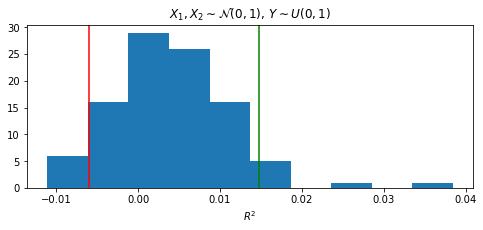

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (8, 3))
plt.hist(scores)
plt.axvline(og_score, c = 'r')
plt.axvline(scores_95, c = 'g')
plt.xlabel(r'$R^2$')
plt.title(r'$X_1,X_2\sim\mathcal{N}(0,1),\,Y\sim U(0,1)$')
plt.savefig('fig2a.jpg', dpi = 500, bbox_inches = "tight")

# Figure 2b

In [19]:
with open('og_scores_2b.csv', newline='') as f:
    reader = csv.reader(f)
    og_scores = [float(x) for x in list(reader)[0]]

with open('quantiles_2b.csv', newline='') as f:
    reader = csv.reader(f)
    quantiles = [float(x) for x in list(reader)[0]]

repeats = 4

for j in range(repeats):
    X = []
    y_fixed = []
    for i in range(100):
        x1 = gauss(0, 1)
        x2 = gauss(0, 1)
        X.append([x1, x2])
        y_fixed.append(uniform(0, 1))
        
    scores, og_score, scores_95 = perm_test_loop(NN_model, X, y_fixed)
    og_scores.append(og_score)
    quantiles.append(scores_95)
    clear_output()
    print("Loop {} finished".format(j))
    
NN_model.load_weights('model.h5')

Loop 3 finished


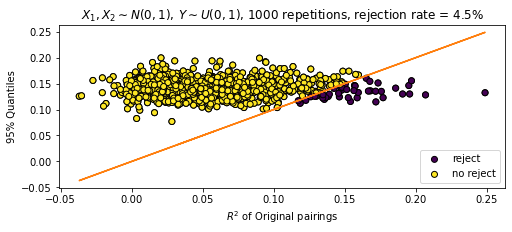

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (8, 3))
ax.scatter(og_scores, quantiles, c = [og_scores[i] > quantiles[i] for i in range(len(og_scores))], ec = 'k', label = 'reject')
ax.scatter(og_scores, quantiles, c = [og_scores[i] < quantiles[i] for i in range(len(og_scores))], ec = 'k', label = 'no reject')
ax.plot(og_scores, og_scores, c = 'C1')
plt.xlabel(r'$R^2$ of Original pairings')
plt.ylabel(r'95% Quantiles')
plt.legend(loc = 'lower right')
rejection_rate = np.mean([og_scores[i] > quantiles[i] for i in range(len(og_scores))])
plt.title(r'$X_1,X_2\sim N(0,1),\,Y\sim U(0,1)$, {} repetitions, rejection rate = {}%'.
          format(len(og_scores), round(rejection_rate * 100, 2)))
plt.savefig('fig2b.jpg', dpi = 500, bbox_inches = "tight")

In [21]:
with open('og_scores_2b.csv', 'w') as f:
    write = csv.writer(f)
     
    write.writerow(og_scores)

In [22]:
with open('quantiles_2b.csv', 'w') as f:
    write = csv.writer(f)
     
    write.writerow(quantiles)

# Figure 4a

In [8]:
X = []
y_fixed = []
for i in range(100):
    x1 = gauss(1, 1)
    x2 = gauss(0, 1)
    X.append([x1, x2])
    eps = gauss(0, 1)
    y_fixed.append(np.log(np.abs(x1)) + x2 ** 2 + eps)

scores, og_score, scores_95 = perm_test_loop(NN_model, X, y_fixed)

NN_model.load_weights('model.h5')

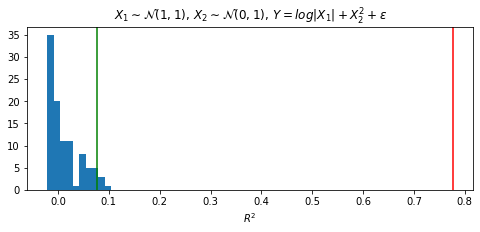

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (8, 3))
plt.hist(scores)
plt.axvline(og_score, c = 'r')
plt.axvline(scores_95, c = 'g')
plt.xlabel(r'$R^2$')
plt.title(r'$X_1\sim\mathcal{N}(1,1),\,X_2\sim\mathcal{N}(0,1),\,Y=log|X_1|+X_2^2+\epsilon$')
plt.savefig('fig4a.jpg', dpi = 500, bbox_inches = "tight")

# Figure 4b

In [5]:
# og_scores = []
# quantiles = []

with open('og_scores.csv', newline='') as f:
    reader = csv.reader(f)
    og_scores = [float(x) for x in list(reader)[0]]

with open('quantiles.csv', newline='') as f:
    reader = csv.reader(f)
    quantiles = [float(x) for x in list(reader)[0]]

repeats = 90

for j in range(repeats):
    X = []
    y_fixed = []
    for i in range(100):
        x1 = gauss(1, 1)
        x2 = gauss(0, 1)
        X.append([x1, x2])
        eps = gauss(0, 1)
        y_fixed.append(np.log(np.abs(x1)) + x2 ** 2 + eps)

    scores, og_score, scores_95 = perm_test_loop(NN_model, X, y_fixed)
    og_scores.append(og_score)
    quantiles.append(scores_95)
    clear_output()
    print("Loop {} finished".format(j))

NN_model.load_weights('model.h5')

KeyboardInterrupt: 

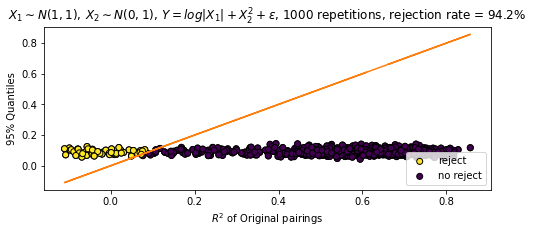

In [6]:
with open('og_scores.csv', newline='') as f:
    reader = csv.reader(f)
    og_scores = [float(x) for x in list(reader)[0]]

with open('quantiles.csv', newline='') as f:
    reader = csv.reader(f)
    quantiles = [float(x) for x in list(reader)[0]]

fig, ax = plt.subplots(1, 1, figsize = (8, 3))
ax.scatter(og_scores, quantiles, c = [og_scores[i] > quantiles[i] for i in range(len(og_scores))], ec = 'k', label = 'reject')
ax.scatter(og_scores, quantiles, c = [og_scores[i] < quantiles[i] for i in range(len(og_scores))], ec = 'k', label = 'no reject')
ax.plot(og_scores, og_scores, c = 'C1')
plt.xlabel(r'$R^2$ of Original pairings')
plt.ylabel(r'95% Quantiles')
plt.legend(loc = 'lower right')
rejection_rate = np.mean([og_scores[i] > quantiles[i] for i in range(len(og_scores))])
plt.title(r'$X_1\sim N(1,1),\,X_2\sim N(0,1),\,Y=log|X_1|+X_2^2+\epsilon$, {} repetitions, rejection rate = {}%'.format(len(og_scores), round(rejection_rate * 100, 2)))
plt.savefig('fig4b.jpg', dpi = 500, bbox_inches = "tight")

In [7]:
with open('og_scores.csv', 'w') as f:
    write = csv.writer(f)
     
    write.writerow(og_scores)

In [8]:
with open('quantiles.csv', 'w') as f:
    write = csv.writer(f)
     
    write.writerow(quantiles)